In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pandas import read_csv

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('AAPL88.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.257641,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.227139,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.365597,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.670671,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.924126,134247600
...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,179.836319,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,178.799149,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,178.888916,62348900


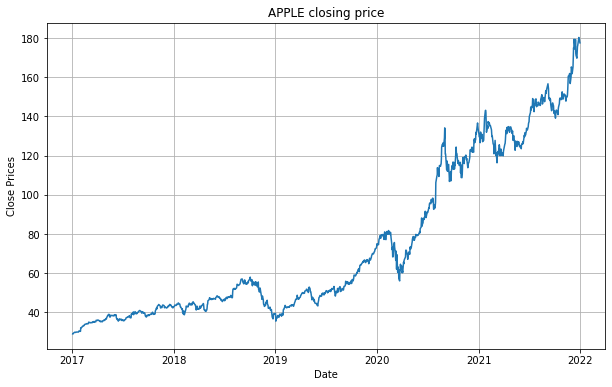

In [4]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('APPLE closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

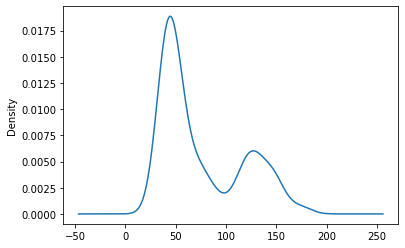

In [5]:
df_close = stock_data['Close']
df_close.plot(kind='kde')

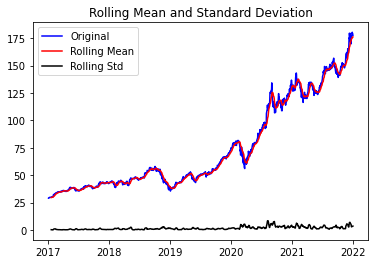

Results of dickey fuller test
Test Statistics                   1.152314
p-value                           0.995639
No. of lags used                 20.000000
Number of observations used    1238.000000
critical value (1%)              -3.435643
critical value (5%)              -2.863877
critical value (10%)             -2.568014
dtype: float64


In [6]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 432x288 with 0 Axes>

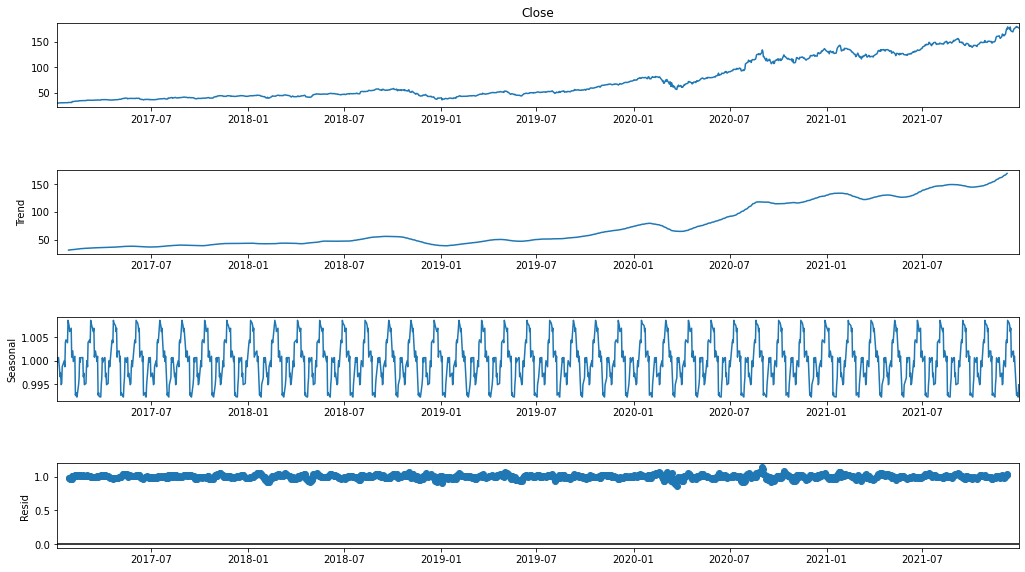

In [7]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


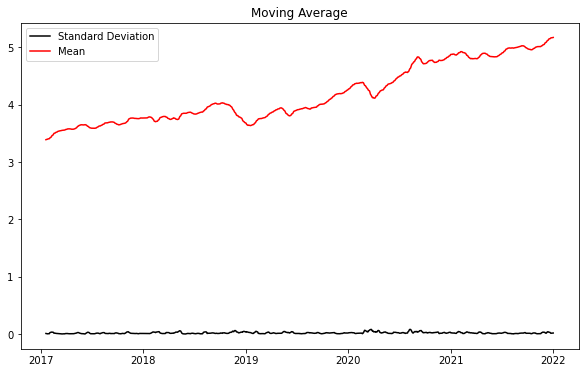

In [8]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

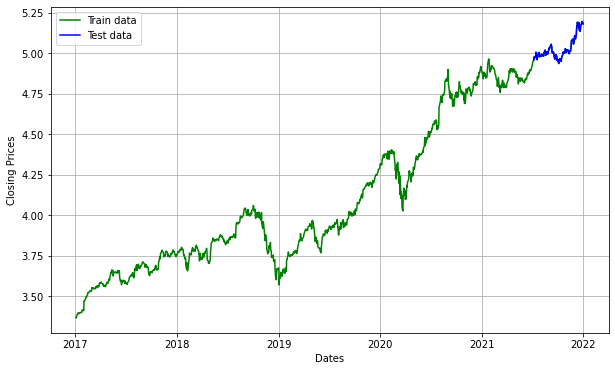

In [9]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5657.544, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5677.324, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5676.353, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5654.029, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5675.566, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5675.592, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5673.494, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5672.110, Time=0.19 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.463 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1130
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2841.662
Date:                Tue, 10 May 2022   AIC                          -5677.324
Time:                       

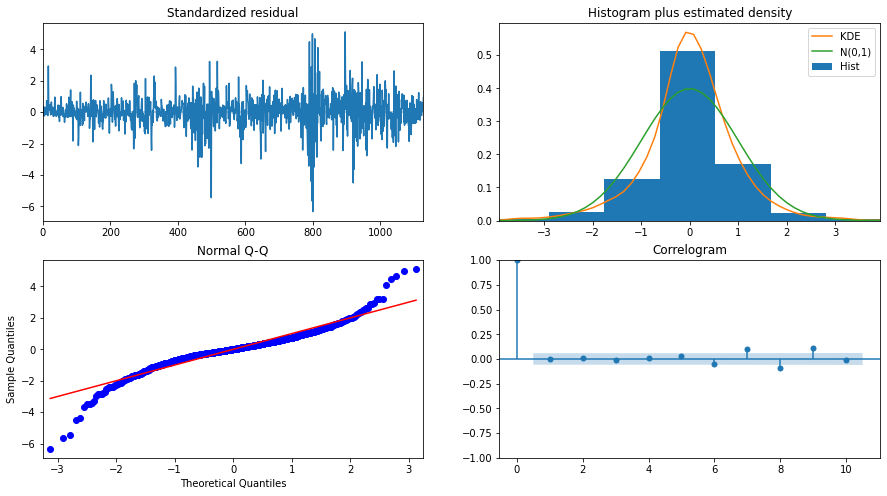

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


In [11]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1129
Model:                 ARIMA(1, 1, 2)   Log Likelihood                2841.801
Method:                       css-mle   S.D. of innovations              0.020
Date:                Tue, 10 May 2022   AIC                          -5673.603
Time:                        16:05:47   BIC                          -5648.457
Sample:                             1   HQIC                         -5664.102
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      2.664      0.008       0.000       0.002
ar.L1.D.Close    -0.2945      0.439     -0.671      0.502      -1.155       0.566
ma.L1.D.Close     0.1584      0.439     

In [12]:
# Forecast
fc, se, conf = fitted.forecast(126, alpha=0.05)  # 95% conf

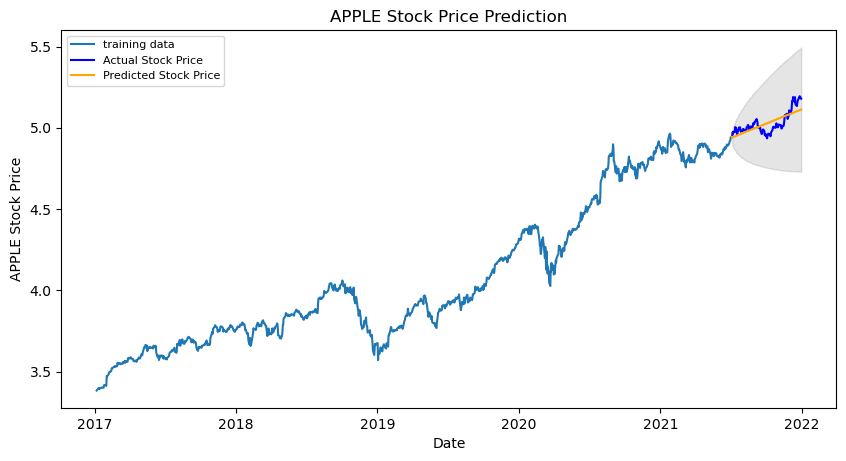

In [13]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('APPLE Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [14]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0021184739520297706
MAE: 0.039025027619821386
RMSE: 0.046026882927586686
MAPE: 0.007748954360441194
